In [ ]:
####################  Deep Learning Script for Bainite - Martensite Classification       ########################

####################  Written by Juancheng Li, Modified by Xiaohan Bie 2022-07-04       ########################

from google.colab import drive
drive.mount('/content/drive')
import os
# folder path
base_dir = '/content/drive/My Drive/SURE Summer 2022/'
train_dir = os.path.join(base_dir, 'train2')
validation_dir = os.path.join(base_dir, 'validation2')
test_dir = os.path.join(base_dir, 'test2')

Mounted at /content/drive


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf


from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers


In [ ]:
# setting parameters
initial_epochs=40
fine_tune_epochs = 30
fine_tune_at = 130
base_learning_rate = 0.001
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
# load image dataset
training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(224, 224))
validation_set = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(224, 224))
# load image dataset
test_set = image_dataset_from_directory(test_dir,
                                             shuffle=False,
                                             batch_size=32,
                                             image_size=(224, 224))


Found 2140 files belonging to 2 classes.
Found 536 files belonging to 2 classes.
Found 180 files belonging to 2 classes.


In [ ]:
# data augmentation (add preprocessing layers to model)
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.2),
  layers.RandomFlip("horizontal_and_vertical"),
])


In [ ]:
# define based model = MobileNetV2
# define input shape as 224 x 224 x 3
# dataset trained on is imagenet
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
base_model = keras.applications.MobileNetV2(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)  # discard FC layer from MobileNetV2 model



9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
# freeze base model layers
base_model.trainable = False

# define input sizes to deep learning model
inputs = keras.Input(shape=(224, 224, 3))

# augment data
x = data_augmentation(inputs) 

preprocess_input = tf.keras.applications.xception.preprocess_input
# preprocess input values scale to (-1,1) to fit Xception  model
x = preprocess_input(x) 

# build FC layer with our image dataset x
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs, outputs)

In [ ]:
# compile model and train
initial_epochs=40
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
history = model.fit(training_set, epochs=initial_epochs, validation_data=validation_set)


Epoch 1/40
67/67 [==============================] - 805s 11s/step - loss: 0.5746 - binary_accuracy: 0.6977 - precision: 0.7112 - recall: 0.7589 - auc: 0.7596 - val_loss: 0.4216 - val_binary_accuracy: 0.8116 - val_precision: 0.8540 - val_recall: 0.7932 - val_auc: 0.9072
Epoch 2/40
67/67 [==============================] - 9s 123ms/step - loss: 0.4392 - binary_accuracy: 0.8000 - precision: 0.8014 - recall: 0.8463 - auc: 0.8775 - val_loss: 0.3703 - val_binary_accuracy: 0.8507 - val_precision: 0.8967 - val_recall: 0.8237 - val_auc: 0.9291
Epoch 3/40
67/67 [==============================] - 8s 109ms/step - loss: 0.3988 - binary_accuracy: 0.8201 - precision: 0.8301 - recall: 0.8463 - auc: 0.9015 - val_loss: 0.3367 - val_binary_accuracy: 0.8638 - val_precision: 0.8881 - val_recall: 0.8610 - val_auc: 0.9404
Epoch 4/40
67/67 [==============================] - 8s 108ms/step - loss: 0.3864 - binary_accuracy: 0.8234 - precision: 0.8300 - recall: 0.8540 - auc: 0.9081 - val_loss: 0.3129 - val_binary_

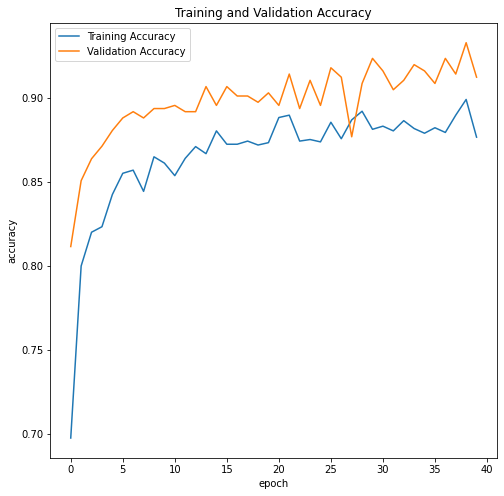

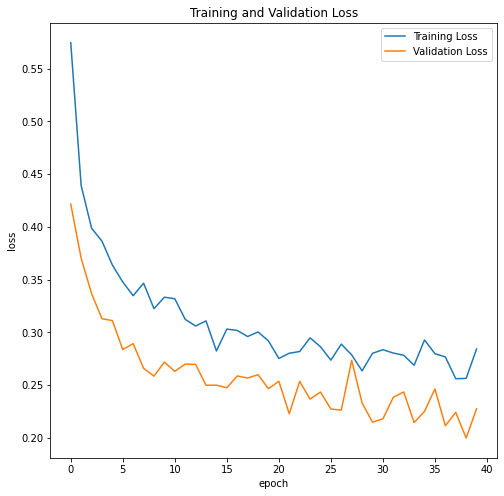

In [ ]:
##################################################
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))


plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()
##################################################

In [ ]:
test = model.evaluate(test_set)
print('test set loss:' + str(test[0]))
print('test set accuracy:' + str(test[1]))

6/6 [==============================] - 79s 12s/step - loss: 0.2370 - binary_accuracy: 0.9000 - precision: 0.9870 - recall: 0.8172 - auc: 0.9793
test set loss:0.23695430159568787
test set accuracy:0.8999999761581421


In [ ]:
base_model = model.layers[4]
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))


for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

loss_function=tf.keras.losses.BinaryCrossentropy()

base_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1*base_learning_rate)

metrics=[keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
model.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

history_fine = model.fit(training_set,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_set)

Number of layers in the base model:  154
Epoch 40/70
67/67 [==============================] - 14s 128ms/step - loss: 0.6434 - binary_accuracy: 0.7201 - precision_1: 0.7348 - recall_1: 0.7691 - auc_1: 0.7733 - val_loss: 0.3877 - val_binary_accuracy: 0.8190 - val_precision_1: 0.7690 - val_recall_1: 0.9593 - val_auc_1: 0.9342
Epoch 41/70
67/67 [==============================] - 8s 111ms/step - loss: 0.3950 - binary_accuracy: 0.8266 - precision_1: 0.8326 - recall_1: 0.8574 - auc_1: 0.9018 - val_loss: 0.3140 - val_binary_accuracy: 0.8825 - val_precision_1: 0.9640 - val_recall_1: 0.8169 - val_auc_1: 0.9642
Epoch 42/70
67/67 [==============================] - 8s 112ms/step - loss: 0.2795 - binary_accuracy: 0.8818 - precision_1: 0.8950 - recall_1: 0.8896 - auc_1: 0.9518 - val_loss: 0.1953 - val_binary_accuracy: 0.9235 - val_precision_1: 0.9568 - val_recall_1: 0.9017 - val_auc_1: 0.9784
Epoch 43/70
67/67 [==============================] - 8s 114ms/step - loss: 0.2388 - binary_accuracy: 0.9107 -

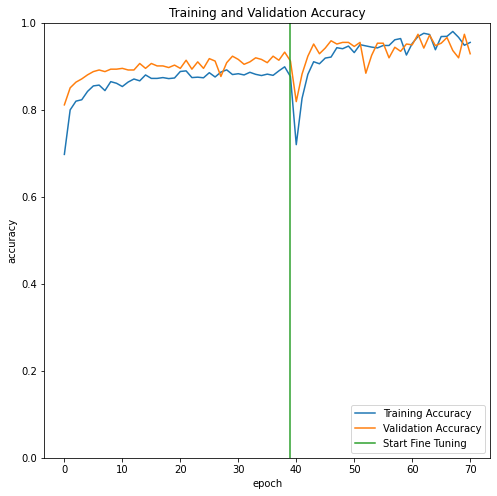

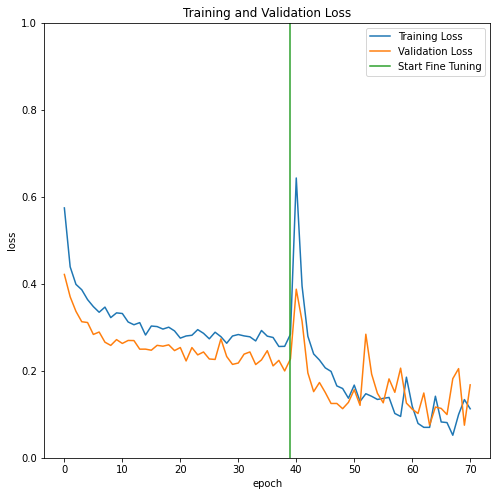

In [ ]:
##########################################################################


acc += history_fine.history['binary_accuracy']
val_acc += history_fine.history['val_binary_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']




plt.figure(figsize=(8, 8))

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(8, 8))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()



#######################################################################

In [ ]:
test2 = model.evaluate(test_set)
print('test set loss:' + str(test2[0]))
print('test set accuracy:' + str(test2[1]))

6/6 [==============================] - 1s 96ms/step - loss: 0.2310 - binary_accuracy: 0.9056 - precision_1: 1.0000 - recall_1: 0.8172 - auc_1: 0.9929
test set loss:0.23097418248653412
test set accuracy:0.9055555462837219


In [ ]:
model.save(os.path.join(base_dir, 'MobileNetV2.h5'))